#лечение несоответствия кол-ва классов (в оригинальной coco - 80)

In [ ]:
# осн средство, должно хватить
https://prnt.sc/w_1ePAX_JQrF
https://prnt.sc/lzp9B2PKbBBI

доп варианты
https://prnt.sc/z2CfhFxEPlX5
https://prnt.sc/CgnT7IusvlQT
https://prnt.sc/D2ArqtUweDta
https://prnt.sc/A9Uy1rL8BDT3

#Загрузка датасета

In [1]:
%cd /content/
!pip uninstall gdown -y && pip install gdown
# важно формат ссылки менять под такой https://drive.google.com/uc?id=1gPg4-HeUmhEo_wl4B_rBFECfEmLeTCxZ
dataset_link = 'https://drive.google.com/uc?id=1RbyDIDUrj6H2MlsjlrRxRoO3zXXovAaC'
!mkdir key_detection
!gdown {dataset_link} -O /content/key_detection/dataset.zip
%cd /content/key_detection/
!unzip dataset.zip

/content
Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=11826954486e180b5d339db422eb9d90b5fc461d2e4a2b4e6bba2d650620de02
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1RbyDIDUrj6H2MlsjlrRxRoO3zXXovAaC
To: /content/key_detection/dataset.zip
100% 236M/236M [00:05<00:00, 41.7MB/s]
/content/key_detection
Archive:  dataset.zip
   creating: object_detection_coco/
   creating: object_detection_coco/test/
   creating: object_detection_coco/test/annotations/
  inflating: object_detection_coco/test/a

#тренировка

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:13:59tcmalloc: large alloc 1147494400 bytes == 0x3a72c000 @  0x7f3620a68615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:29tcmalloc: large alloc 1434370048 bytes == 0x7ed82000 @  0x7f3620a68615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

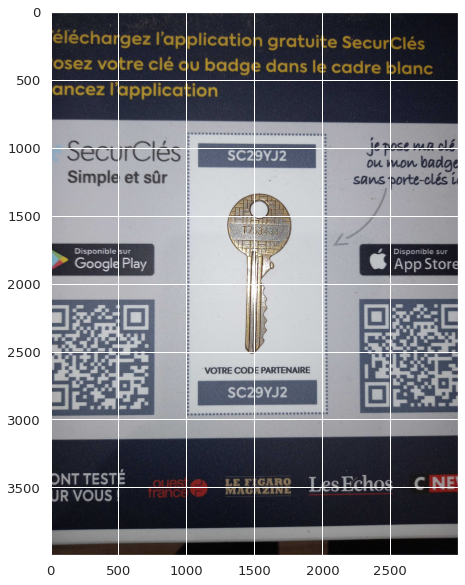

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt


DATA_DIR = '/content/key_detection/object_detection_coco/train/images/'
ANNO_DIR = '/content/key_detection/object_detection_coco/train/annotations/'

img = mmcv.imread(f'{DATA_DIR}B.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
%cd /content/key_detection/mmdetection/

from mmdet.apis import set_random_seed
from mmcv import Config

model_type = "ssd"

cfg = Config.fromfile('/content/key_detection/mmdetection/configs/ssd/ssd512_coco.py')

dataset_type = 'CocoDataset'
classes = ('key',)

# Modify dataset type and path
cfg.dataset_type = dataset_type
cfg.data_root = '/content/key_detection/'

cfg.data.train.dataset.type = dataset_type
cfg.data.train.dataset.data_root = '/content/key_detection/object_detection_coco/'
cfg.data.train.dataset.ann_file = 'train/annotations/instances_default.json'
cfg.data.train.dataset.img_prefix = 'train/images/'

cfg.data.test.type = dataset_type
cfg.data.test.data_root = '/content/key_detection/object_detection_coco/'
cfg.data.test.ann_file = 'test/annotations/instances_default.json'
cfg.data.test.img_prefix = 'test/images/'

cfg.model.bbox_head.num_classes = 1
cfg.load_from = '/content/key_detection/mmdetection/checkpoints/ssd512_coco_20210803_022849-0a47a1ca.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
#print(f'Config:\n{cfg.pretty_text}')


/content/key_detection/mmdetection


In [ ]:
cfg.runner.max_epochs = 5

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp
import mmcv
import numpy as np

# Build dataset
datasets = [build_dataset(cfg.data.train)]
#datasets[0].CLASSES = classes

# Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
cfg.device='cuda'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-06-20 08:38:23,633 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-06-20 08:38:23,638 - mmdet - INFO - load checkpoint from local path: /content/model.pth
2022-06-20 08:38:23,786 - mmdet - INFO - Start running, host: root@da644356b9f3, work_dir: /content/key_detection/mmdetection/tutorial_exps
2022-06-20 08:38:23,789 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW

In [ ]:
import glob
test = glob.glob('/content/test/*')

In [ ]:
### разобраться, с выбрасыванием картинок без разметки
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
# модель сохраняется chekpointом - видимо в папке tutorial_exps
#CF003020_1_5b8970b7012d2b03fc45994cb682ad5a.jpg
#CF004243_5_4e83a966b2436fcdfcc6bf4655c86527.jpg
test_key = 'CF002974_4_16bd2d4c4b75f8810b9f97593a4a75ce.jpg'
#img = mmcv.imread(f'/content/test/{test_key}')
img = mmcv.imread(test[5])

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from mmdet.apis import init_detector, inference_detector, train_detector
model = init_detector(cfg, cfg.load_from, device='cuda:0')

load checkpoint from local path: /content/model.pth


In [ ]:
def scale_img(img, dim):
    y = img.shape[0]
    x = img.shape[1]
    ratio = y/x
    return mmcv.imresize(img, (dim, int(ratio*dim)))

In [ ]:
mmcv.imresize(img, (1000, 600), return_scale=True)

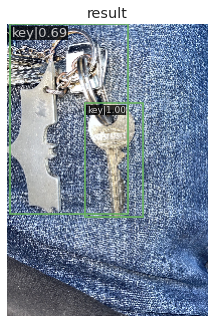

In [ ]:
import mmcv
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
img = scale_img(mmcv.imread(test[0]), 200)
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

#CPU only inference

In [2]:
# install dependencies: (cpu only)
!pip install torch==1.9.0+cpu torchvision==0.10.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cpu/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 175.5 MB 12 kB/s 
     |████████████████████████████████| 15.7 MB 106 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.0+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0+cpu which is 

In [3]:
import os
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
import numpy as np

In [4]:
#скачать свой чекпоинт
%cd /content/
!pip uninstall gdown -y && pip install gdown
# важно формат ссылки менять под такой https://drive.google.com/uc?id=1gPg4-HeUmhEo_wl4B_rBFECfEmLeTCxZ
chkp_link = 'https://drive.google.com/uc?id=1rJsDc3JoUzcFaiqLomStIiB8QBkTq2_Z'
!gdown {chkp_link} -O /content/model.pth


/content
Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gdown-4.4.0-py3-none-any.whl
Downloading...
From: https://drive.google.com/uc?id=1rJsDc3JoUzcFaiqLomStIiB8QBkTq2_Z
To: /content/model.pth
100% 195M/195M [00:04<00:00, 40.8MB/s]


In [5]:
%cd /content/key_detection/mmdetection/

from mmdet.apis import set_random_seed
from mmcv import Config

model_type = "ssd"

cfg = Config.fromfile('/content/key_detection/mmdetection/configs/ssd/ssd512_coco.py')

dataset_type = 'CocoDataset'
classes = ('key',)

# Modify dataset type and path
cfg.dataset_type = dataset_type
cfg.data_root = '/content/key_detection/'

cfg.data.train.dataset.type = dataset_type
cfg.data.train.dataset.data_root = '/content/key_detection/object_detection_coco/'
cfg.data.train.dataset.ann_file = 'train/annotations/instances_default.json'
cfg.data.train.dataset.img_prefix = 'train/images/'

cfg.data.test.type = dataset_type
cfg.data.test.data_root = '/content/key_detection/object_detection_coco/'
cfg.data.test.ann_file = 'test/annotations/instances_default.json'
cfg.data.test.img_prefix = 'test/images/'

cfg.model.bbox_head.num_classes = 1
cfg.load_from = '/content/key_detection/mmdetection/checkpoints/ssd512_coco_20210803_022849-0a47a1ca.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
#print(f'Config:\n{cfg.pretty_text}')

cfg.load_from = '/content/model.pth'
cfg.runner.max_epochs = 5

/content/key_detection/mmdetection
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [6]:
def scale_img(img, dim):
    y = img.shape[0]
    x = img.shape[1]
    ratio = y/x
    return mmcv.imresize(img, (dim, int(ratio*dim)))

def scale_back_bbox(result, ratio):
    y_ratio, x_ratio = ratio

    scaled_result = []
    for bbox in result:
        if len(bbox) > 0:
            bbox[0][0] *= y_ratio
            bbox[0][2] *= y_ratio
            bbox[0][1] *= x_ratio
            bbox[0][3] *= x_ratio
        else:
            bbox = [[]]
        scaled_result.append(bbox)
    return scaled_result

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import os.path as osp
import mmcv
import numpy as np

img = mmcv.imread('/content/key_detection/object_detection_coco/test/images/CF005742_3_a4f1214a1397b1c45a26e3020106469a.jpg')

scaled_img = scale_img(img, 100)

model = init_detector(cfg, cfg.load_from, device='cpu')

result = inference_detector(model, scaled_img)

scaled_result = scale_back_bbox(result, (img.shape[0] / scaled_img.shape[0], img.shape[1] / scaled_img.shape[1]))
show_result_pyplot(model, img, scaled_result)

In [8]:
from glob import glob
to_test = glob('/content/key_detection/object_detection_coco/test/images/*')

In [9]:
model = init_detector(cfg, cfg.load_from, device='cpu')

# если осталось несколько - то взять самый большой, например
def filter_low_prob(res):
    filtered = []
    for bbox in res[0]:        
        if len(bbox) == 0 or bbox[4] > 0.2:
            filtered.append(bbox)

    if len(filtered) > 1:
        filtered = sorted(filtered[0], key = lambda x: x[4], reverse=True)[0]

    return [np.array(filtered)]

def get_bbox(path, model):
    img = mmcv.imread(path)
    scaled_img = scale_img(img, 100)
    result = inference_detector(model, scaled_img)
    scaled_result = scale_back_bbox(result, (img.shape[0] / scaled_img.shape[0], img.shape[1] / scaled_img.shape[1]))
    bbox = filter_low_prob(scaled_result)
    if len(bbox[0]) != 1:
        print(f'img - {path}')
    return bbox

load checkpoint from local path: /content/model.pth


In [ ]:
to_test = glob('/content/test/*')

In [17]:
bboxes = {}

for img in to_test:
    detection = get_bbox(img, model)
    bboxes[img] = detection

img - /content/key_detection/object_detection_coco/test/images/CF003281_1_ab1aea1ec8620b2717d802d2f566a364.jpg
img - /content/key_detection/object_detection_coco/test/images/CF004317_3_0f13648e4f252ddab4b1f0637c585061.jpg


In [62]:
def crop_img(path, bbox):
    add = 0.1
    img = mmcv.imread(path)
    i_h, i_w, _ = img.shape
    h = int(bbox[3] - bbox[1])
    w = int(bbox[2] - bbox[0])
    y = int(bbox[1] - add*h)
    x = int(bbox[0] - add*w)
    if y < 0: y = 0
    if x < 0: x = 0
    h = int((1 + 2*add)*h)
    w = int((1 + 2*add)*w)
    if h + y > i_h: h = i_h - y
    if w + x > i_w: w = i_w - x
    return img[y:y+h, x:x+w]
    
im = crop_img('/content/key_detection/object_detection_coco/test/images/CF005742_3_a4f1214a1397b1c45a26e3020106469a.jpg', bboxes['/content/key_detection/object_detection_coco/test/images/CF005742_3_a4f1214a1397b1c45a26e3020106469a.jpg'][0][0])

(3564, 2376, 3)


In [73]:
#reload module magic without kernel restating
import importlib
import proc_detection
importlib.reload(proc)
from proc_detection import key_detection

In [70]:
from proc_detection import key_detection

detectron = key_detection()

ImportError: ignored

In [74]:
detectron = key_detection()

load checkpoint from local path: /content/model.pth


In [77]:
im = detectron.proc_img('/content/key_detection/object_detection_coco/test/images/CF005742_3_a4f1214a1397b1c45a26e3020106469a.jpg')

/content/key_detection/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


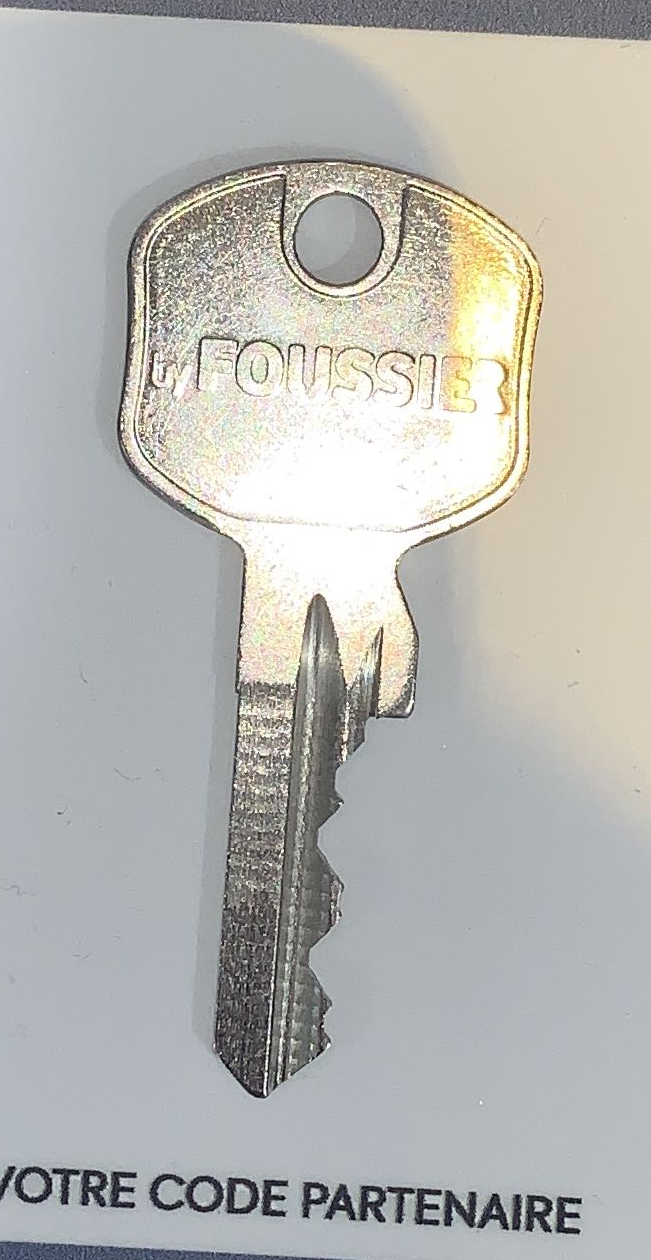

In [80]:
from google.colab.patches import cv2_imshow
cv2_imshow(im)